In [ ]:
def bg_scenario(scename, patient: str, results: str, scenario: str, state: str=None):
    """
    Process the results of a blood glucose scenario
    :param scename: the name of the scenario
    :param patient: the patient file location
    :param results: the results of the scenario (location string)
    :param scenario: the scenario file string
    :param state: the state file of the scenario
    """
    basecmdstr = f"bg-scenario name {scename} patient {patient} results {results} scenario {scenario} -q"
    if state is not None:
        basecmdstr += f" state {state}"
    # execute the command
    !{basecmdstr}


def multithread_patient_generation()

In [ ]:
bg_scenario("sepsis", "../customconfigs/Male_44_Normal.xml", "../output/sepsis", "../customconfigs/SepticShock.xml")

In [ ]:
!/bin/howtos/howto-patientgeneration

In [ ]:
# !bg-cli -j 16 generate sepsis population data/templates/generator/population.template.xml
!bg-cli generate population data/templates/generator/population.template.xml

In [ ]:
!bg-cli generate states

In [ ]:
import os
import random
import pandas as pd

os.chdir("/opt/biogears/core/biogears_py")

# sepsis mic values candidates
mic_sepsis_cands = ["8", "16", "32"]
severity_cands = ["Severe"]
treatment_plan_cands = ["None"]
antibiodelay_cands = ["46", "32"]
treatmentinterv_cands = ["30", "60"]


# try to do the howto-PatientGeneration (multi threading)
# firsr load the patient states file names and write them into the config file format
def prepare_config_file():
    patient_states = os.listdir("states")
    lines = []
    for file in patient_states:
        # randomly choose an severety from the list of the severity_cands
        severity = random.choice(severity_cands)
        # randomly choose an treatment plan from the list of the treatment_plan_cands
        treatment_plan = random.choice(treatment_plan_cands)
        # randomly choose an antibio delay from the list of the antibiodelay_cands
        antibio_delay = random.choice(antibiodelay_cands)
        # randomly choose an treatment interv from the list of the treatmentinterv_cands
        treatment_interv = random.choice(treatmentinterv_cands)
        # randomly choose an mic value from the list of the mic_sepsis_cands
        mic_value = random.choice(mic_sepsis_cands)
        # append the series as: Severity, PLAN, MIC, antibiodelay_cands, Interval for treatments, [file, Duration]
        line = [severity, treatment_plan, mic_value, antibio_delay, treatment_interv, 48, "states/" + file]
        lines.append(line)
    # create the dataframe
    df = pd.DataFrame(lines, columns=None)
    return df

In [ ]:
config_csv = prepare_config_file()
# save the config_csv to the config folder
config_csv.to_csv("config/patientgenconfig.csv", index=False)

In [ ]:
!/usr/bin/howtos/howto-patientgeneration --config config/patientgenconfig.csv

## Next process the output csv files to extract the patient vt traces

In [ ]:
import pandas as pd
import numpy as np
import os
# import matplotlib.pyplot as plt
import re

In [ ]:
folder = "runtime/states"
files = os.listdir(folder)
def get_csv_and_log_files(folder):
    files = os.listdir(folder)
    csv_files = [f for f in files if f.endswith(".csv")]

    return csv_files

def load_csv_files_and_logs(folder):
    experiments = get_csv_and_log_files(folder)
    data = []
    for csv_file in experiments:
        csv = pd.read_csv(folder + "/" + csv_file)
        if len(csv) < 36:
            continue
        if "Piperacillin-BloodConcentration" in csv.columns:
            csv = csv.drop(columns=["Piperacillin-BloodConcentration"])
        if "Tazobactam-BloodConcentration" in csv.columns:
            csv = csv.drop(columns=["Tazobactam-BloodConcentration"])
        if "Piperacillin-BloodConcentration(ug/mL)" in csv.columns:
            csv = csv.drop(columns=["Piperacillin-BloodConcentration(ug/mL)"])
        if "Tazobactam-BloodConcentration(ug/mL)" in csv.columns:
            csv = csv.drop(columns=["Tazobactam-BloodConcentration(ug/mL)"])
        csv = csv.drop(columns=["Magnesium-BloodConcentration"])
        # only keep the csvs that length is larger than 500
        if len(csv) > 60:
            # set the time series as the index
            csv.set_index("Time(s)", inplace=True)
            # set the type of the index as datetime(s)
            csv.index = pd.to_datetime(csv.index, unit="s")
            # aggregate (mean) over hours
            csv = csv.resample("h").mean()
            # then change the index to normal range, not time stamps
            csv.reset_index(drop=True, inplace=True)
            data.append([csv_file, csv])

    return data


def combine_all_csvs(data):
    csvs = []
    for filename, csv in data:
        # extract the patient id from the log file
        # patient id str like: Starting states/id096_Male_Short_YoungAdult_UnderWeight@0s.xml
        # we need to match the part: 096 and convert it into an integer, the digit count is at least 3 (can larger)
        # patient_id_str = re.search(r"states/id(\d+)_", log).group(0)
        # add the patient id to the csv
        patient_id = int(filename.split("_")[0].replace("id", ""))
        multiindex = pd.MultiIndex.from_product([[patient_id], csv.index], names=["patient_id", "time"])
        csv.index = multiindex
        csvs.append(csv)
    # concatenate all the csvs
    all_data = pd.concat(csvs)
    return all_data


def add_sepsis_labels(whole_csv):
    # add the sepsis column based on the qsofa score
    whole_csv = whole_csv.copy()
    whole_csv["qsofa"] = 0
    whole_csv.loc[whole_csv["SystolicArterialPressure(mmHg)"] <= 100, "qsofa"] += 1
    whole_csv.loc[whole_csv["RespirationRate(1/min)"] >= 22, "qsofa"] += 1
    whole_csv["sepsis"] = 0
    whole_csv.loc[whole_csv["qsofa"] >= 2, "sepsis"] = 1
    return whole_csv


def get_sepsispatient_ids(wholecsv):
    sepsis_pids = []
    for pid in wholecsv.index.get_level_values(0).unique():
        if 1 in wholecsv.loc[pid]["sepsis"].values:
            sepsis_pids.append(pid)
    return sepsis_pids


def get_sepsisandnonsepsispatient_subcsv(wholecsv):
    sepsis_ids = get_sepsispatient_ids(wholecsv)
    sepsis_csvs = []
    for pid in sepsis_ids:
        sepsis_csvs.append(wholecsv.loc[[pid]])
    sepsis_csvs = pd.concat(sepsis_csvs)

    nonsepsis_csvs = wholecsv.drop(sepsis_csvs.index)
    return sepsis_csvs, nonsepsis_csvs


def plot_dist_first_occ_sepsis_time(whole_csv):
    sepsis_pids = whole_csv[whole_csv["sepsis"] == 1].index.get_level_values(0).unique()
    sepsis_csvs = []
    for pid in sepsis_pids:
        sepsis_csvs.append(whole_csv.loc[[pid]])
    sepsis_csvs = pd.concat(sepsis_csvs)
    first_occ_times = []
    for pid in sepsis_pids:
        subcsv = sepsis_csvs.loc[[pid]]
        subcsv = subcsv[subcsv["sepsis"] == 1]
        if len(subcsv) > 0:
            first_occ_time = subcsv.index[0][1]
            first_occ_times.append(first_occ_time)
    return first_occ_times

In [ ]:
csvs_and_fnames = load_csv_files_and_logs(folder)
whole_csv = combine_all_csvs(csvs_and_fnames)
whole_csv = add_sepsis_labels(whole_csv)
# first_occ_times = plot_dist_first_occ_sepsis_time(whole_csv)

In [ ]:
print("sepsis value counts:")
print(whole_csv['sepsis'].value_counts())
print("complete csv length")
print(len(whole_csv))
print("total number of patients:")
print(len(whole_csv.index.get_level_values(0).unique()))

In [ ]:
whole_csv.columns

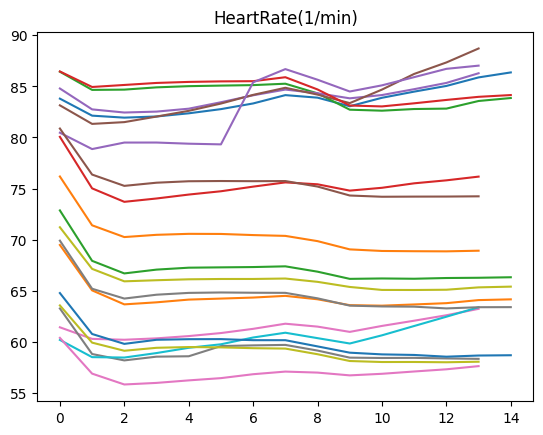

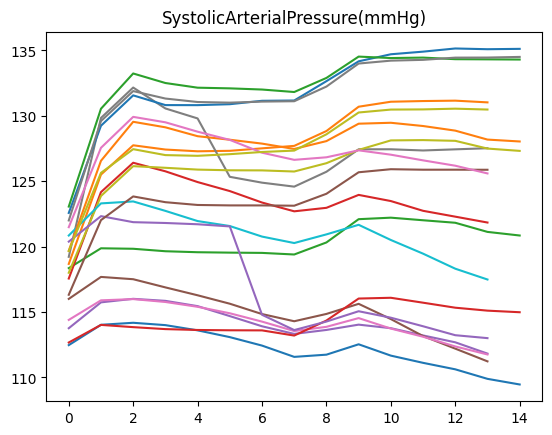

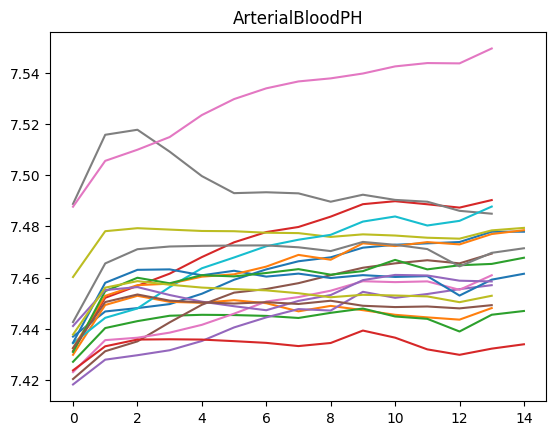

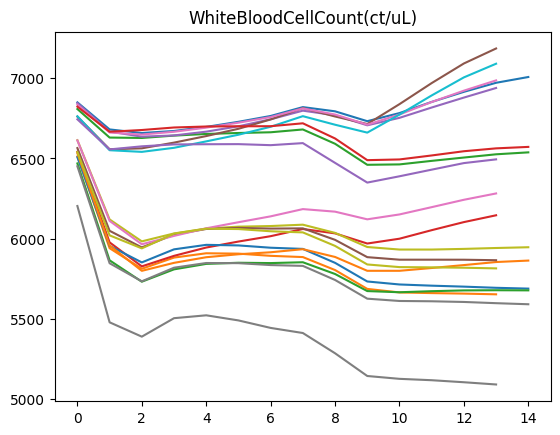

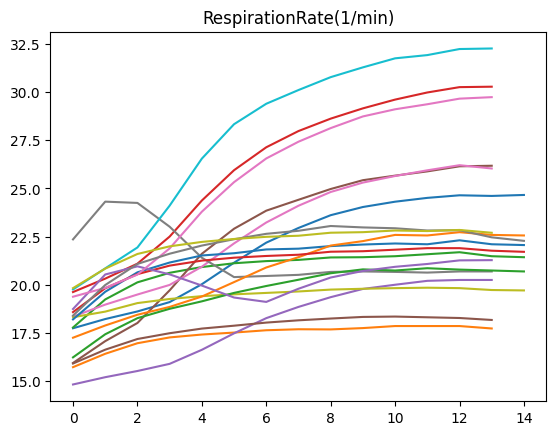

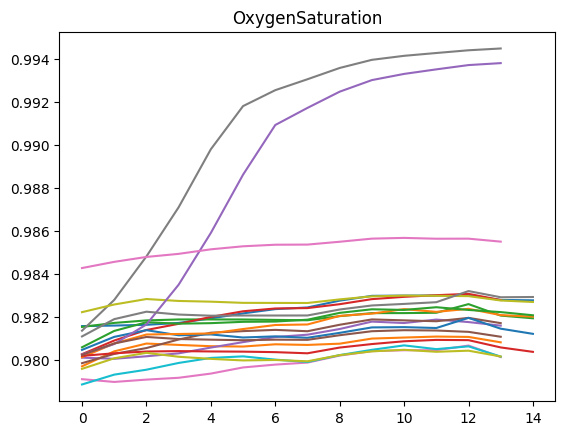

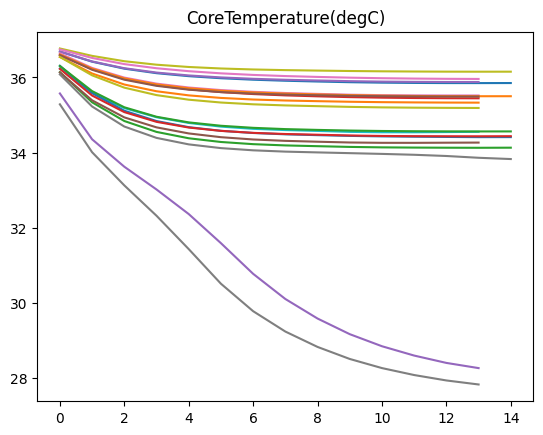

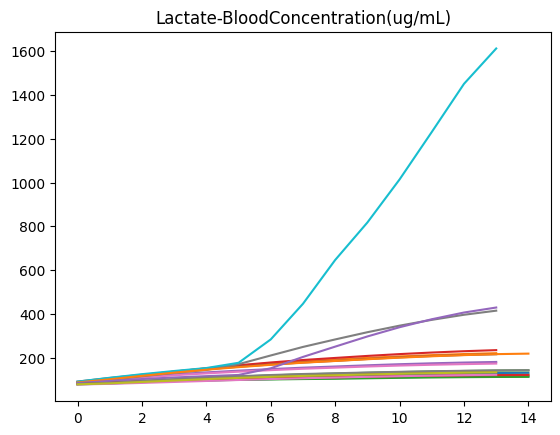

In [10]:
import matplotlib.pyplot as plt


# plot the data curves of all samples
pids = whole_csv.index.get_level_values(0).unique()
cols_to_plot = ["HeartRate(1/min)", "SystolicArterialPressure(mmHg)", "ArterialBloodPH", "WhiteBloodCellCount(ct/uL)", "RespirationRate(1/min)",
                "OxygenSaturation", "CoreTemperature(degC)", "Lactate-BloodConcentration(ug/mL)"]
vitalsign_names = []
for col in cols_to_plot:
    for _pid in pids:
        subcsv = whole_csv.loc[[_pid]]
        subcsv = subcsv.droplevel(0)
        subcsv = subcsv[cols_to_plot]
        plt.plot(subcsv[col])
    plt.title(col)
    plt.show()

# Next is the presentation related files and figures preparation

In [ ]:
# get the mean values of all columns of sepsis 1 and 0 columns separately
sepsis_1 = whole_csv[whole_csv['sepsis'] == 1]
sepsis_0 = whole_csv[whole_csv['sepsis'] == 0]
# sepsis1_pids = sepsis_1.index.get_level_values(0).unique()
# sepsis0_pids = whole_csv.index.get_level_values(0).unique().difference(sepsis1_pids)
# sepsis_1 = whole_csv.loc[sepsis1_pids]
# sepsis_0 = whole_csv.loc[sepsis0_pids]

sepsis_1_mean = sepsis_1.groupby(level=0).mean().mean()
sepsis_0_mean = sepsis_0.groupby(level=0).mean().mean()

In [ ]:
sepsis_1_mean

In [ ]:
sepsis_0_mean

In [ ]:
# get the first sepsis_subcsvs pid subcsv
pid = sepsis_1.index.get_level_values(0).unique()[0]
pid_subcsv = sepsis_1.loc[[pid]]
pid_subcsv.index = pid_subcsv.index.droplevel(0)
pid_subcsv[['SystolicArterialPressure(mmHg)']].plot(subplots=True, figsize=(5, 5))
plt.show()

In [ ]:
# get the first nonsepsis_subcsvs pid subcsv
pid = nonsepsis_csvs.index.get_level_values(0).unique()[1]
pid_subcsv = nonsepsis_csvs.loc[[pid]]
pid_subcsv.index = pid_subcsv.index.droplevel(0)
pid_subcsv[['Bicarbonate-BloodConcentration(ug/mL)']].plot(subplots=True, figsize=(5, 5))
plt.show()

In [ ]:
whole_csv.to_csv("runtime/output/wholecsv.csv")

In [ ]:
whole_csv.columns

In [ ]:
# convert the format from the bg column names to physionet style


# Next Process the prediction testing using the XGBoost

In [ ]:
def slid_convet(whole_csv, win_size, step_size, pred_horizon):
    # slid processing over the second level of the multiindex
    # output shape: N, win_size, features
    pids = whole_csv.index.get_level_values(0).unique()
    samples = []
    labels = []
    for _id in pids:
        subdf = whole_csv.loc[[_id]]
        t_s = 0
        while t_s + win_size + pred_horizon < len(subdf):
            samples_tmp = subdf.iloc[t_s:t_s + win_size]
            featcols = [col for col in samples_tmp.columns if col != "sepsis"]
            samples.append(samples_tmp[featcols].values)
            labels_tmp = subdf.iloc[t_s + win_size + pred_horizon]
            labels_tmp = labels_tmp["sepsis"]
            labels.append(labels_tmp)
            t_s += step_size
    return np.array(samples), np.array(labels)

In [ ]:
samples, labels = slid_convet(whole_csv, 12, 5, 6)

In [ ]:
# do the xgboost classification of training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.33, random_state=42)

import xgboost as xgb

model = xgb.XGBClassifier()
# wrap the feature to dataframe with correct feature names
wholecsvfeatcols = [col for col in whole_csv.columns if col != "sepsis"]
reshaped_feat_cols = []
for i in range(samples.shape[1]):
    for col in wholecsvfeatcols:
        reshaped_feat_cols.append(f"{col}_past_{i}")

X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1), columns=reshaped_feat_cols)
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], -1), columns=reshaped_feat_cols)

model.fit(X_train_df, y_train)

preds = model.predict(X_test_df)

from sklearn.metrics import classification_report

print(classification_report(y_test, preds > 0.5))

# plot the feature importance
xgb.plot_importance(model)

In [ ]:
# next trying training the model using the feat max - min values
pos_samples = samples[labels == 1]
neg_samples = samples[labels == 0]

# get the max and min values of the features
max_vals = np.max(samples, axis=1)
min_vals = np.min(samples, axis=1)
maxmindiff_vals = max_vals - min_vals
maxmindiff_vals_df = pd.DataFrame(maxmindiff_vals, columns=wholecsvfeatcols)

# xgboost model
X_train, X_test, y_train, y_test = train_test_split(maxmindiff_vals_df, labels, test_size=0.33, random_state=42)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

preds = model.predict(X_test)

print(classification_report(y_test, preds > 0.5))

# plot the feature importance
xgb.plot_importance(model)

In [ ]:
# Next get the data and train a model to fit the Bicarbonate-BloodConcentration(ug/mL) values
# first get the hist dist of the values
bicarbonate_mmol_L = whole_csv["Bicarbonate-BloodConcentration(ug/mL)"] * 0.0164

In [ ]:
"""
Index(['CTSresistance', 'HeartRate(1/min)', 'MeanArterialPressure(mmHg)',
       'SystolicArterialPressure(mmHg)', 'DiastolicArterialPressure(mmHg)',
       'CardiacOutput(L/min)', 'HemoglobinContent(g)',
       'CentralVenousPressure(mmHg)', 'Hematocrit', 'ArterialBloodPH',
       'UrinationRate(mL/hr)', 'WhiteBloodCellCount(ct/uL)',
       'UrineProductionRate(mL/min)', 'RespirationRate(1/min)',
       'OxygenSaturation', 'CarbonDioxideSaturation', 'CoreTemperature(degC)',
       'SkinTemperature(degC)', 'Bicarbonate-BloodConcentration(ug/mL)',
       'Creatinine-BloodConcentration(ug/mL)',
       'Lactate-BloodConcentration(ug/mL)', 'sepsis'],
      dtype='object')
"""

def extract_bicarbonate_fit_data(wholecsv):
    cols = wholecsv.columns.tolist()
    # first get the col index of the Bicarbonate-BloodConcentration(ug/mL) values
    bicarbonate_col_idx = cols.index("Bicarbonate-BloodConcentration(ug/mL)")
    # get the bicarbonate values
    bicarbonate_vals_mmol_L = wholecsv.iloc[:, bicarbonate_col_idx] * 0.0164
    bicarbonate_vals_mmol_L.name = "HCO3"

    # then discretize the bicarbonate_vals_mmol_L based on 30, 60, 90 % percentiles
    bicarbonate_vals_mmol_L_disc = pd.qcut(bicarbonate_vals_mmol_L, q=[0, 0.33, 0.66, 1], labels=[0, 1, 2])

    # get the real-time vital sign cols
    vital_sign_cols = ["HeartRate(1/min)", "OxygenSaturation", "SkinTemperature(degC)", 
                       "SystolicArterialPressure(mmHg)", "MeanArterialPressure(mmHg)", 
                       "DiastolicArterialPressure(mmHg)", "RespirationRate(1/min)"]
    # get the col indexes of the vital signs
    vital_sign_col_idxs = [cols.index(col) for col in vital_sign_cols]
    # get the vital sign values
    vital_sign_vals = wholecsv.iloc[:, vital_sign_col_idxs]
    # rename the vital_sign_vals cols
    vital_sign_vals.columns = ["HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp"]

    # discretize the vital sign values based on 30, 60, 90 % percentiles
    vital_sign_vals_disc = vital_sign_vals.apply(lambda x: pd.qcut(x, q=[0, 0.33, 0.66, 1], labels=[0, 1, 2]), axis=0)

    return bicarbonate_vals_mmol_L_disc, vital_sign_vals_disc

In [ ]:
bicarbonate_vals_mmol_L, vital_sign_vals = extract_bicarbonate_fit_data(whole_csv)

In [ ]:
# apply the xgboost to train the bicarbonate values using the vital signs
# first get the training and testing data

X_train, X_test, y_train, y_test = train_test_split(vital_sign_vals, bicarbonate_vals_mmol_L, test_size=0.2, random_state=42)
dtrainmatrix = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtestmatrix = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
# train using dmatrix
param = {'max_depth': 2, 'eta': 1, 'objective': 'multi:softmax', 'num_class': 3}
num_round = 10
bst = xgb.train(param, dtrainmatrix, num_round)
# predict
preds = bst.predict(dtestmatrix)
print(classification_report(y_test, preds))

In [ ]:
X_train.columns

In [ ]:
# save the model to biogears_py/models
bst.save_model("biogears_py/models/bicarbonate_fit_model.json")

In [ ]:
# using the linear regression to fit the bicarbonate values
from sklearn.linear_model import LinearRegression

"""
Index(['CTSresistance', 'HeartRate(1/min)', 'MeanArterialPressure(mmHg)',
       'SystolicArterialPressure(mmHg)', 'DiastolicArterialPressure(mmHg)',
       'CardiacOutput(L/min)', 'HemoglobinContent(g)',
       'CentralVenousPressure(mmHg)', 'Hematocrit', 'ArterialBloodPH',
       'UrinationRate(mL/hr)', 'WhiteBloodCellCount(ct/uL)',
       'UrineProductionRate(mL/min)', 'RespirationRate(1/min)',
       'OxygenSaturation', 'CarbonDioxideSaturation', 'CoreTemperature(degC)',
       'SkinTemperature(degC)', 'Bicarbonate-BloodConcentration(ug/mL)',
       'Creatinine-BloodConcentration(ug/mL)',
       'Lactate-BloodConcentration(ug/mL)', 'sepsis'],
      dtype='object')
"""

def extract_bicarbonate_fit_data_nodisc(wholecsv):
    cols = wholecsv.columns.tolist()
    # first get the col index of the Bicarbonate-BloodConcentration(ug/mL) values
    bicarbonate_col_idx = cols.index("Bicarbonate-BloodConcentration(ug/mL)")
    # get the bicarbonate values
    bicarbonate_vals_mmol_L = wholecsv.iloc[:, bicarbonate_col_idx] * 0.0164
    bicarbonate_vals_mmol_L.name = "HCO3"
    bicarbonate_vals_mmol_L = (bicarbonate_vals_mmol_L - bicarbonate_vals_mmol_L.mean()) / bicarbonate_vals_mmol_L.std()

    # get the real-time vital sign cols
    vital_sign_cols = ["HeartRate(1/min)", "OxygenSaturation", "SkinTemperature(degC)", 
                       "SystolicArterialPressure(mmHg)", "MeanArterialPressure(mmHg)", 
                       "DiastolicArterialPressure(mmHg)", "RespirationRate(1/min)"]
    # get the col indexes of the vital signs
    vital_sign_col_idxs = [cols.index(col) for col in vital_sign_cols]
    # get the vital sign values
    vital_sign_vals = wholecsv.iloc[:, vital_sign_col_idxs]
    # rename the vital_sign_vals cols
    vital_sign_vals.columns = ["HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp"]
    vital_sign_vals = (vital_sign_vals - vital_sign_vals.mean()) / vital_sign_vals.std()

    return bicarbonate_vals_mmol_L, vital_sign_vals

bicarbonate_vals_mmol_L, vital_sign_vals = extract_bicarbonate_fit_data_nodisc(whole_csv)

X_train, X_test, y_train, y_test = train_test_split(vital_sign_vals, bicarbonate_vals_mmol_L, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, preds)

# save the model
import pickle

with open("biogears_py/models/bicarbonate_fit_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Train the model using the slid conversion raw feature

In [ ]:
realtimevts_cols = ["HeartRate(1/min)", "OxygenSaturation", "SkinTemperature(degC)",
                        "SystolicArterialPressure(mmHg)", "MeanArterialPressure(mmHg)",
                        "DiastolicArterialPressure(mmHg)", "RespirationRate(1/min)"]


def slid_convet_onlyrealtvts_disc(whole_csv, win_size, step_size, pred_horizon):
    
    # slid processing over the second level of the multiindex
    # output shape: N, win_size, features
    pids = whole_csv.index.get_level_values(0).unique()
    samples = []
    labels = []
    for _id in pids:
        subdf = whole_csv.loc[[_id]]
        subdf = subdf[realtimevts_cols + ["sepsis"]]
        # rename the columns
        subdf.columns = ["HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp", "sepsis"]
        t_s = 0
        while t_s + win_size + pred_horizon < len(subdf):
            samples_tmp = subdf.iloc[t_s:t_s + win_size]
            featcols = [col for col in samples_tmp.columns if col != "sepsis"]
            samples.append(samples_tmp[featcols].values)
            labels_tmp = subdf.iloc[t_s + win_size + pred_horizon]
            labels_tmp = labels_tmp["sepsis"]
            labels.append(labels_tmp)
            t_s += step_size
    return np.array(samples), np.array(labels)

# discretize the whole csv
whole_csv_disc = whole_csv.copy()
for col in whole_csv.columns:
    if col != "sepsis" and col in realtimevts_cols:
        whole_csv_disc[col] = pd.qcut(whole_csv[col], q=[0, 0.33, 0.66, 1], labels=[0, 1, 2])
        whole_csv_disc[col] = whole_csv_disc[col].astype(int)

samples, labels = slid_convet_onlyrealtvts_disc(whole_csv_disc, 12, 5, 6)

In [ ]:
# do the xgboost classification of training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.33, random_state=42)

renamedcols = ["HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp"]

import xgboost as xgb

model = xgb.XGBClassifier()
# wrap the feature to dataframe with correct feature names
reshaped_feat_cols = []
for i in range(samples.shape[1]):
    for col in renamedcols:
        reshaped_feat_cols.append(f"{col}_past_{i}")

X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1), columns=reshaped_feat_cols)
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], -1), columns=reshaped_feat_cols)

model.fit(X_train_df, y_train)

preds = model.predict(X_test_df)

from sklearn.metrics import classification_report

print(classification_report(y_test, preds > 0.5))

# plot the feature importance
xgb.plot_importance(model)

In [ ]:
# save the model
model.save_model("biogears_py/models/sepsis_fit_model.json")

In [ ]:
# next we train the model to use the feature to predict bicarbonate
def extract_bicarbonate_fit_data_nodisc(wholecsv):
    cols = wholecsv.columns.tolist()
    # first get the col index of the Bicarbonate-BloodConcentration(ug/mL) values
    bicarbonate_col_idx = cols.index("Bicarbonate-BloodConcentration(ug/mL)")
    # get the bicarbonate values
    bicarbonate_vals_mmol_L = wholecsv.iloc[:, bicarbonate_col_idx] * 0.0164
    bicarbonate_vals_mmol_L.name = "HCO3"
    bicarbonate_vals_mmol_L = (bicarbonate_vals_mmol_L - bicarbonate_vals_mmol_L.mean()) / bicarbonate_vals_mmol_L.std()

    # get the real-time vital sign cols
    vital_sign_cols = ["HeartRate(1/min)", "OxygenSaturation", "SkinTemperature(degC)", 
                       "SystolicArterialPressure(mmHg)", "MeanArterialPressure(mmHg)", 
                       "DiastolicArterialPressure(mmHg)", "RespirationRate(1/min)"]
    # get the col indexes of the vital signs
    vital_sign_col_idxs = [cols.index(col) for col in vital_sign_cols]
    # get the vital sign values
    vital_sign_vals = wholecsv.iloc[:, vital_sign_col_idxs]
    # rename the vital_sign_vals cols
    vital_sign_vals.columns = ["HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp"]
    vital_sign_vals = (vital_sign_vals - vital_sign_vals.mean()) / vital_sign_vals.std()

    return bicarbonate_vals_mmol_L, vital_sign_vals

bicarbonate_vals_mmol_L, vital_sign_vals = extract_bicarbonate_fit_data_nodisc(whole_csv)

X_train, X_test, y_train, y_test = train_test_split(vital_sign_vals, bicarbonate_vals_mmol_L, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, preds)

# save the model
import pickle

with open("biogears_py/models/bicarbonate_fit_model.pkl", "wb") as f:
    pickle.dump(model, f)

## Inspect the patient labels (whether they are full sepsis 1 all the time)

In [ ]:
# read the csv file
import pandas as pd
import matplotlib.pyplot as plt


whole_csv = pd.read_csv("output/wholepsv.csv", index_col=["pid", "time"])
whole_csv = whole_csv.drop("SepsisLabel", axis=1)

def is_sepsis(whole_csv):
    whole_csv = whole_csv.copy()
    # judge whethe the patient timestep is sepsis based on the qsofa score
    # qsofa score is the sum of the following conditions:
    # 1. respiratory rate >= 22
    # 2. altered mental status (not supported, so currently ignore that)
    # 3. systolic blood pressure <= 100
    whole_csv["qsofa"] = 0
    whole_csv.loc[whole_csv["Resp"] >= 22, "qsofa"] += 1
    whole_csv.loc[whole_csv["SBP"] <= 100, "qsofa"] += 1
    # if both conditions met, then set the label to 1
    whole_csv["sepsis"] = 0
    whole_csv.loc[whole_csv["qsofa"] >= 2, "sepsis"] = 1
    return whole_csv

def plot_dist_first_occ_sepsis_time(whole_csv):
    sepsis_pids = whole_csv[whole_csv["sepsis"] == 1].index.get_level_values(0).unique()
    sepsis_csvs = []
    for pid in sepsis_pids:
        sepsis_csvs.append(whole_csv.loc[[pid]])
    sepsis_csvs = pd.concat(sepsis_csvs)
    first_occ_times = []
    for pid in sepsis_pids:
        subcsv = sepsis_csvs.loc[[pid]]
        subcsv = subcsv[subcsv["sepsis"] == 1]
        if len(subcsv) > 0:
            first_occ_time = subcsv.index[0][1]
            first_occ_times.append(first_occ_time)
    return first_occ_times

whole_csv = is_sepsis(whole_csv)
# plot the distribution of the first occurence of sepsis
first_occ_times = plot_dist_first_occ_sepsis_time(whole_csv)
plt.hist(first_occ_times, bins=100)
plt.show()

In [ ]:
whole_csv.index.get_level_values(0).unique()

In [ ]:
whole_csv[whole_csv["sepsis"] == 1].index.get_level_values(0).unique()

In [ ]:
whole_csv

In [ ]:
whole_csv.index.get_level_values('pid').unique()